In [1]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import warnings

warnings.filterwarnings("ignore")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Validation via a Bayesian approach

To create a baseline model for our SCM approach, we try to specify it using a Bayesian mixture model. This should be able to capture the granularity of the individual products. We will not overcomplicate and specify different too many product and aggregate interactions, but focus more on product level. The ideas is that it'll be a linear regression model to give an indicator of general impact that we should expect to see. We fit it via a MCMC based approach to sample the posterior. See [here](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-simpsons-paradox.html) for more details.

Before reading on, I recommend a quick intro to [Bayesian statistics](https://www.youtube.com/watch?v=3jP4H0kjtng) first. MCMC bypasses the need to find conjugate priors and directly calculates the posteriors by an algorithm.
For an intro to MCMC, I also recommend this quick [intro](https://www.youtube.com/watch?v=Jr1GdNI3Vfo) on Youtube

In [60]:
flc = pd.read_csv('cache_flc.csv')

In [3]:
flc[['is_holiday','is_weekend','promos']] = flc[['is_holiday','is_weekend','promos']].astype(int)

In [5]:
is_holiday= flc.is_holiday
is_weekend= flc.is_weekend
promos= flc.promos
log_unit_mrp= flc.log_unit_mrp
log_d= flc.log_d
units = flc.units
ttl_investment = flc.ttl_investment

In [6]:
new_cat, new_cat_labels = flc.new_cat.factorize()

In [7]:
coords = {"new_cat": new_cat_labels}

# General model

First, a model for promos. We'll try to estimate the causal link via a logistic function that predicts the propensity for a promo given a holiday, which then gets fed into a larger model. 
 - $ promos \sim holiday + noise $ (with logistic link)


We'll assume unit count of product follows by Poisson/Neg Binomial link. Some of the mixed effects due to interaction terms will be modelled via an indicator term if the effect is present or not. So imagine if promos was not present, then this term would disappear, otherwise, it would be something that depends on the other factors as well.

$ log(units) \sim log(d)+log(mrp)+holiday+weekend+ttlinvest+promos+terms_{cross} $

where mrp is the pure pricing term, d indicates the discount term, ttl_invest indicates the marketing term

 $ terms_{cross} \sim promos*log(d) + promos*log(mrp) + weekend*log(mrp) + weekend*log(d) + holiday*log(mrp) + holiday*log(d) $


The below is a simple model that asssumes that besides propensity of promos that is shared on aggregate, the individual product demands control most of the other factors. For now, and simplicity, we assume the product demands are not from a shared distribution. For future, I would hyperparametrize isolated holiday/weekend/promo effects as these seem more homogenous. 

Some of the hyperparameters to set the priors are done via the following.
1. For those that are relatively independent of product, we'll just set it using empirical data with some variance. (Promo and holiday propensity)
2. Else, we set it so that we assume that there is no effect, but that variance is a fair balance between what we will observe in our causal inference simulations. 


In [ ]:

with pm.Model(coords=coords) as hierarchical_on_granular:
    log_d = pm.MutableData("log_d", flc.log_d, dims="obs_id")
    log_unit_mrp = pm.MutableData("log_unit_mrp", flc.log_unit_mrp, dims="obs_id")
    units = pm.MutableData("units", np.exp(flc.units), dims="obs_id")
    is_weekend = pm.MutableData("is_weekend", flc.is_weekend, dims="obs_id")
    is_holiday = pm.MutableData("is_holiday", flc.is_holiday, dims="obs_id")
    ttl_investment = pm.MutableData("ttl_investment", flc.ttl_investment, dims="obs_id")
    
    # Priors
    hol_promo_co = pm.Normal("hol_promo_co", mu=0.7 ,sigma= 0.2) # If 1, p -> 14-> 25%
    promo_propensity_co = pm.Normal("promo_propensity_co", mu=-1.788,sigma=0.1) # Baseline, assuming no holiday.  
    g_d_co = pm.Normal("g_d_co", mu=0 ,sigma=2, dims="new_cat") # The rest, baseline no effect, but still large possibility to have one. 
    g_mrp_co = pm.Normal("g_mrp_co", mu=0 ,sigma=2, dims="new_cat") # Var 2 chosen that movement of log units is generally less than 2.
    hol_co = pm.Normal("hol_co", mu=0 ,sigma=1, dims="new_cat")
    week_co = pm.Normal("week_co", mu=0 ,sigma=1, dims="new_cat")
    promos_co = pm.Normal("promos_co", mu=0 ,sigma=1, dims="new_cat")
    ttl_investment_co = pm.Normal("ttl_investment_co", mu=0 ,sigma=1, dims="new_cat")
    cross_promo_d_co = pm.Normal("cross_promo_d_co", mu=0 ,sigma=2, dims="new_cat")
    cross_promo_mrp_co = pm.Normal("cross_promo_mrp_co", mu=0 ,sigma=2, dims="new_cat")
    cross_week_mrp_co = pm.Normal("cross_week_mrp_co", mu=0 ,sigma=2, dims="new_cat")
    cross_week_d_co = pm.Normal("cross_week_d_co", mu=0 ,sigma=2, dims="new_cat")
    cross_hol_mrp_co = pm.Normal("cross_hol_mrp_co", mu=0 ,sigma=2, dims="new_cat")
    cross_hol_d_co = pm.Normal("cross_hol_d_co", mu=0 ,sigma=2, dims="new_cat")
    base_unit_co = pm.Normal("base_unit_co", mu=0 ,sigma=5, dims="new_cat") # Set higher due to intercept setting. 
    alpha = pm.Exponential("alpha", 0.5, dims="new_cat") # Mean is 2, which is ok when looking at spread. 

    promos_p = pm.Deterministic("promos_p", pm.math.invlogit(hol_promo_co*is_holiday + promo_propensity_co),
                               )
    
    # Promos uses a logistic regression. 
    promo_model = pm.Bernoulli("promos", promos_p, observed=promos,dims='obs_id')
    units_model = pm.Deterministic("units_model", 
                                   g_d_co[new_cat]*log_d 
                                   + g_mrp_co[new_cat]*log_unit_mrp 
                                   + hol_co[new_cat]*is_holiday 
                                   + week_co[new_cat]*is_weekend
                                   + promos_co[new_cat]*promo_model 
                                   + cross_promo_d_co[new_cat]*promo_model*log_d
                                   + cross_promo_mrp_co[new_cat]*promo_model*log_unit_mrp
                                   + cross_week_mrp_co[new_cat]*is_weekend*log_unit_mrp
                                   + cross_week_d_co[new_cat]*is_weekend*log_d 
                                   + cross_hol_mrp_co[new_cat]*is_holiday*log_unit_mrp 
                                   + cross_hol_d_co[new_cat]*is_holiday*log_d 
                                   + ttl_investment_co[new_cat]*ttl_investment
                                   + base_unit_co[new_cat],dims='obs_id')

    exp_model = pm.math.exp(units_model)
    
    # Data likelihood
    unit_like = pm.NegativeBinomial("unit_like", mu=exp_model, alpha=alpha[new_cat], observed=units)


Plotting the above model to visualize what it'll look like in terms of a distribution level.

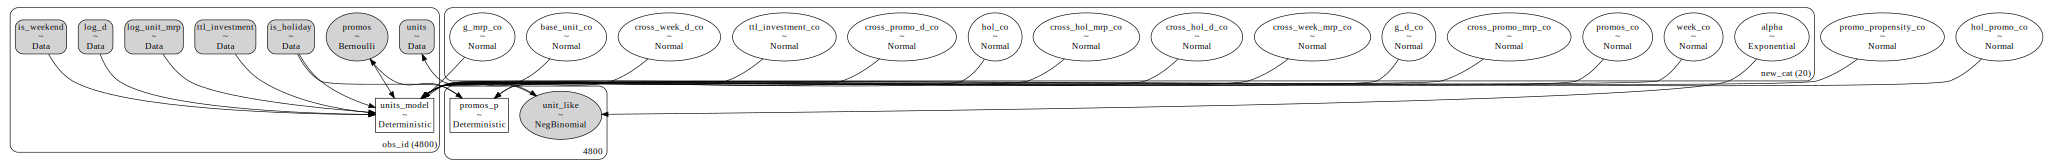

In [9]:
pm.model_to_graphviz(hierarchical_on_granular)

In [ ]:
## Sample the posterior via MCMC

with hierarchical_on_granular:
    hierarchical_on_granular_trace = pm.sample(chains=3,tune=2000)

In [92]:
## Saving for future analysis.

hierarchical_on_granular_trace.to_netcdf('hmodel_trace.nc')

'hmodel_trace.nc'

Let's plot the coefficients of the non cross effect terms first. The x% HDI here represents the highest density interval, which is the shortest interval containing the mean with x% probability based on our sampled data. Think of it as similar to a credible interval or confidence interval.

As expected, discounts have the largest perceivable effect on our total units purchased, given our prior assumption of no effect, and it does follow that the lower the total discounted price, the more confident of our estimate of larger effect. It is noteworthy that even after setting the prior for the discount to have larger variance, they have more certainty of an effect compared to the other coefficients, which have a much smaller effect and possibly larger variance to the effect. 

We note, in particular, the following
1. Ttl investment DOES seem to have some effect, (maybe smaller than discounts), when we try to break it down by product groups. The low variation may be because of the lack of data variation here. 

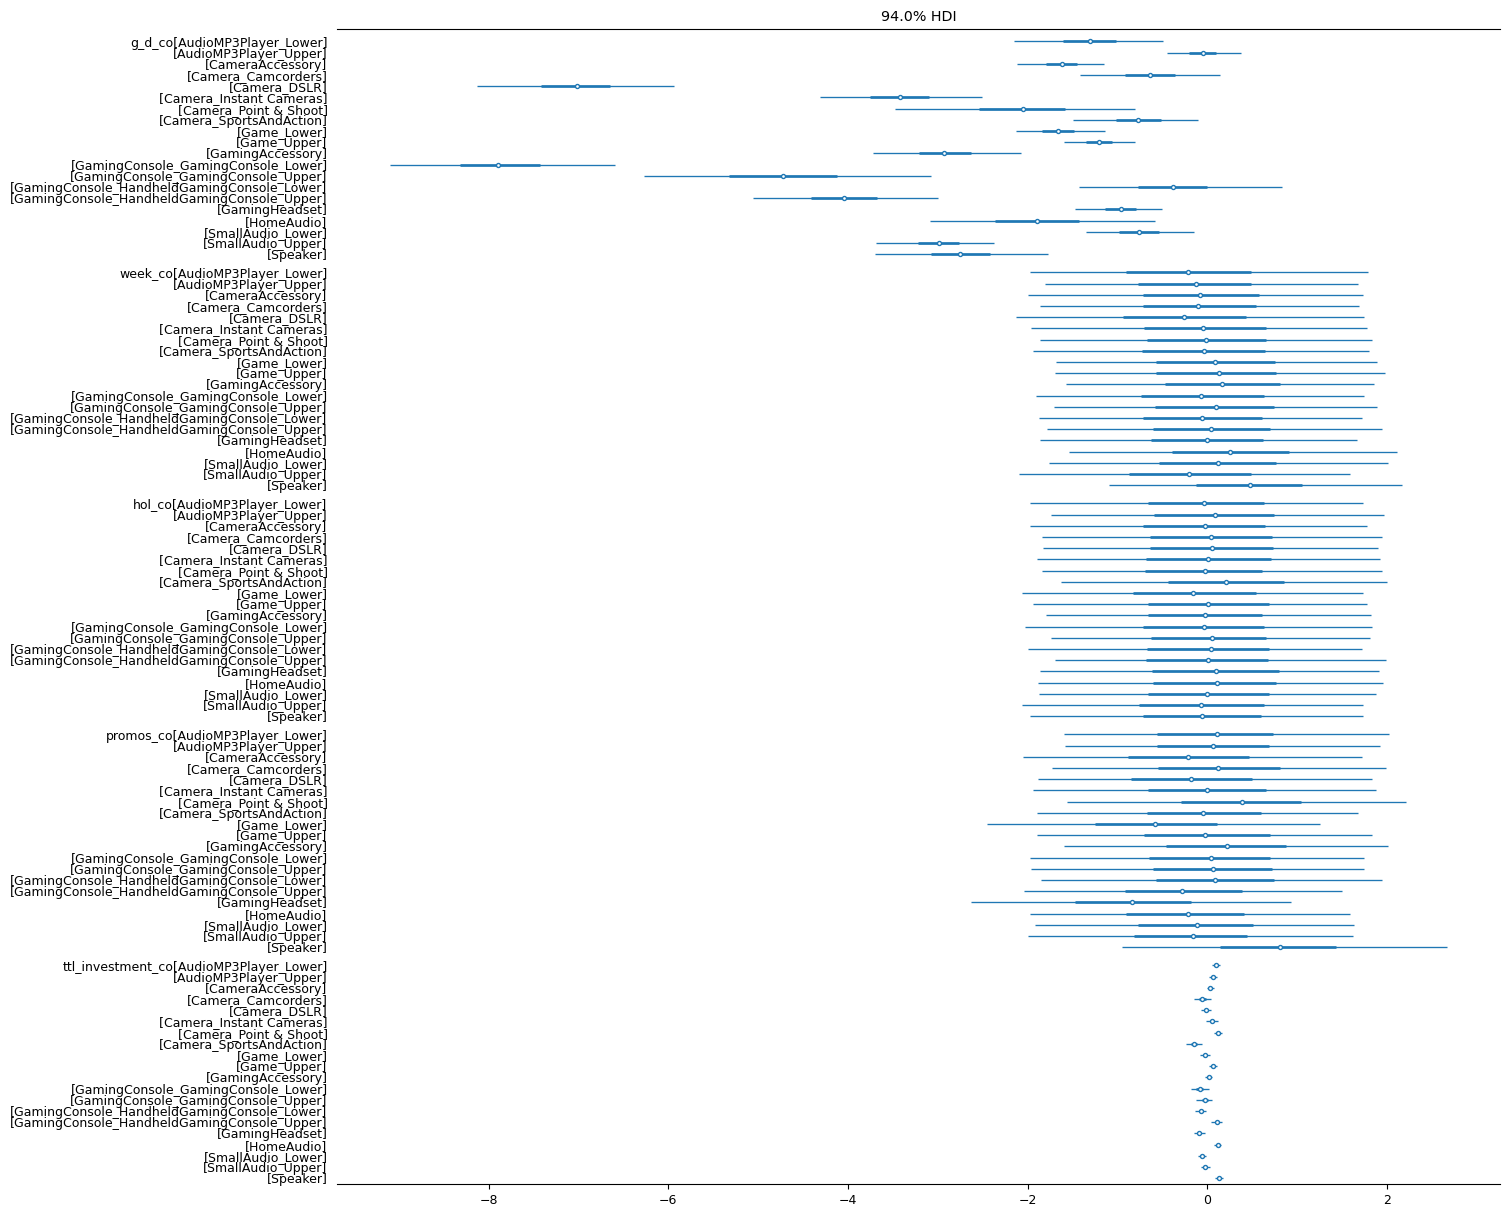

In [77]:
## Comparing discount to other coefficients that have weaker effect

ax = az.plot_forest(
    hierarchical_on_granular_trace,
    var_names=["g_d_co","week_co","hol_co","promos_co","ttl_investment_co"],
    combined=True,
    figsize=(15, 15),
    textsize=9,
)

In terms of whether the price of the object does affect the demand, the mixed model also picked up a similar signal where the variance also for the most part shrunk and there are signs of some effect, that may depend on the product category as to whether it would be positive or negative. Even though, this is a linear model, there is some interaction between this pricing term and the discount term and we may need to read it as they could be coupled. 

In the below chart, just to highlight a few findings
- Camera DSLR had a strong effect where a higher price might influence the purchase, but this should be taken into account with the strong discount coefficient below as well. (fig) , which might suggest the combination of value for money may be what is driving demand given that this market is targerted more towards the high end.
- In contrast, speakers tends to have lower prices contributing more towards higher purchases. It could be that the market is more homogenous and there is more space for competition and less differentiation here.

What one could do with this information is that this could give an indication to the type of user that might like to spend in each product, and try to tailor our campaigns better to them, although I don't recommend reading too much into this plot, as this model is more used to validate our findings rather than to draw new conclusions. 

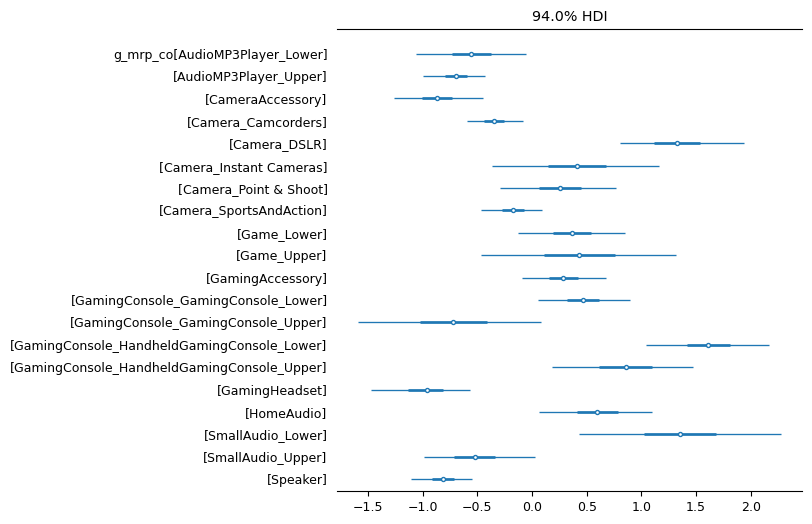

In [80]:
## Plot out the coefficients of the pricing for different products. 

ax = az.plot_forest(
    hierarchical_on_granular_trace,
    var_names=["g_mrp_co"],
    combined=True,
    figsize=(6, 6),
    textsize=9,
)

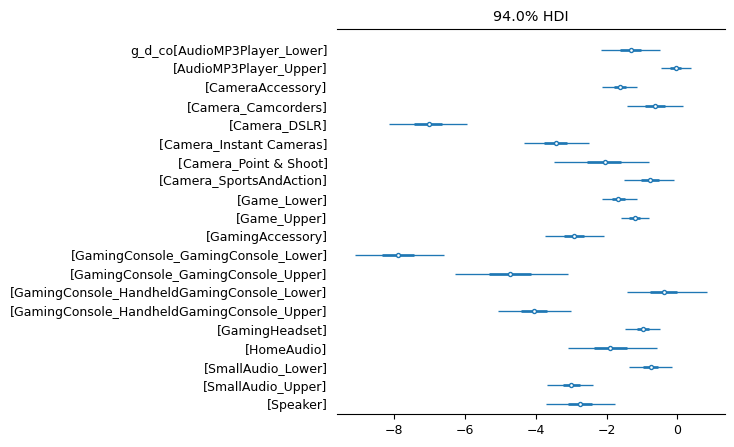

In [90]:
# Plotting pure discounts for assessing general effect
ax = az.plot_forest(
    hierarchical_on_granular_trace,
    var_names=["g_d_co"],
    combined=True,
    figsize=(5, 5),
    textsize=9,
)

Given that discounts play such a large role, we plot the reference trace distribution to see how the posterior has been sampled. The left hand is an estimate of the posterior distribution based on the MCMC via a kernel density estimate, and the right is what the MCMC sampled for each step. For the most part, there seems to be an average mixture for the MCMC process, which is good enough with other models in tandem, but will need to be refined for better inference (some of the chains may not be centered properly, notice the different bumps that we observe in the KDE for different chains for each spending category). 

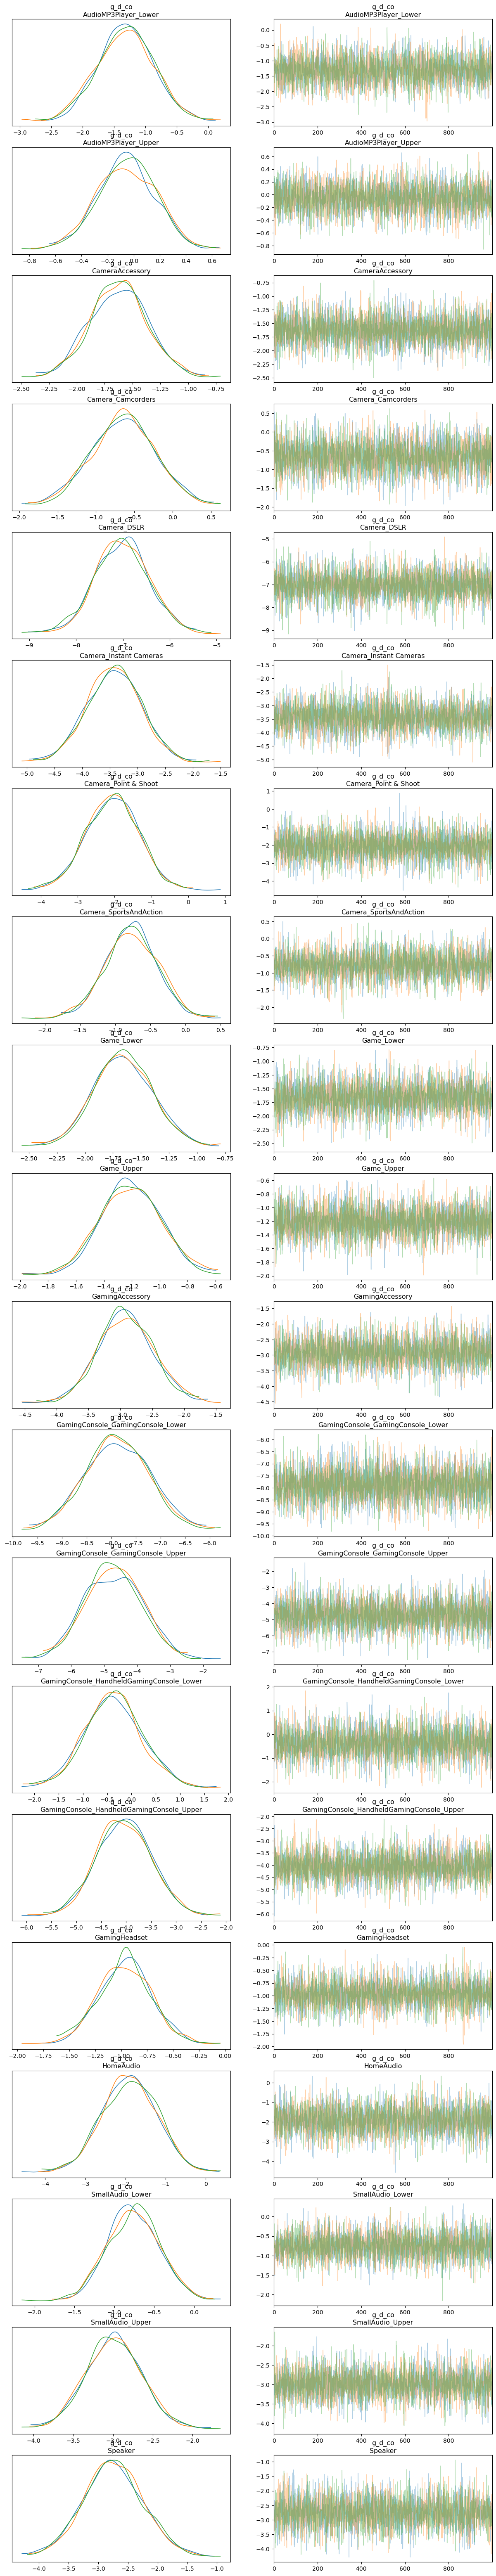

In [87]:
axes = az.plot_trace(hierarchical_on_granular_trace, 
              var_names=["g_d_co"], 
              compact=False,
             figsize=(15, 80))

We finally also examine cross effects in terms of how the different time sensitive terms may interact with our discount terms. For the most part, we note that the only cross interaction term with large enough effect to discuss is the cross promo and discount terms. In this case, it also depends on the product on how it would increase or decrease the ability to make a purchase is influenced by the promo or discount or not. This likely suggests that promos themselves, don't have a strong effect on their own, but have most of their effect acting through discounts. 

From this, we can takeaway, that promos should be more carefully designed with product in mind to highlight the discounts, rather than a general sales for higher efficacy.

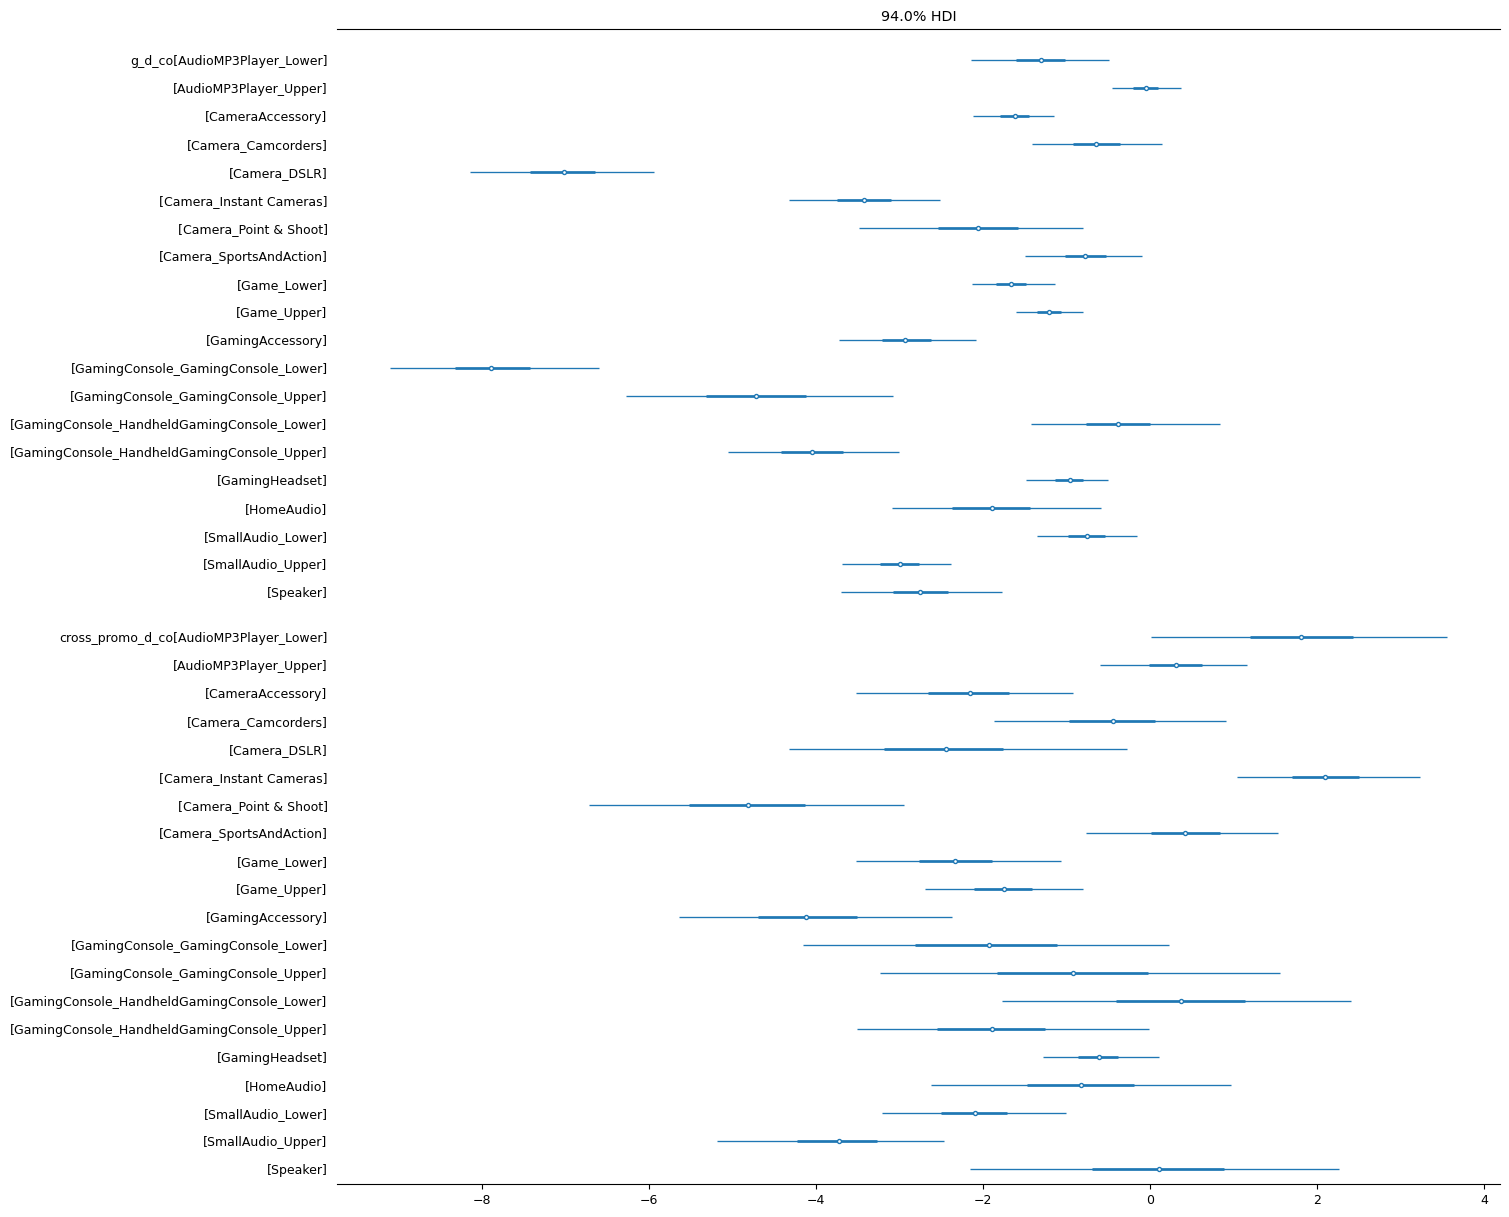

In [79]:
ax = az.plot_forest(
    hierarchical_on_granular_trace,
    var_names=["g_d_co","cross_promo_d_co"],
    combined=True,
    figsize=(15, 15),
    textsize=9,
)

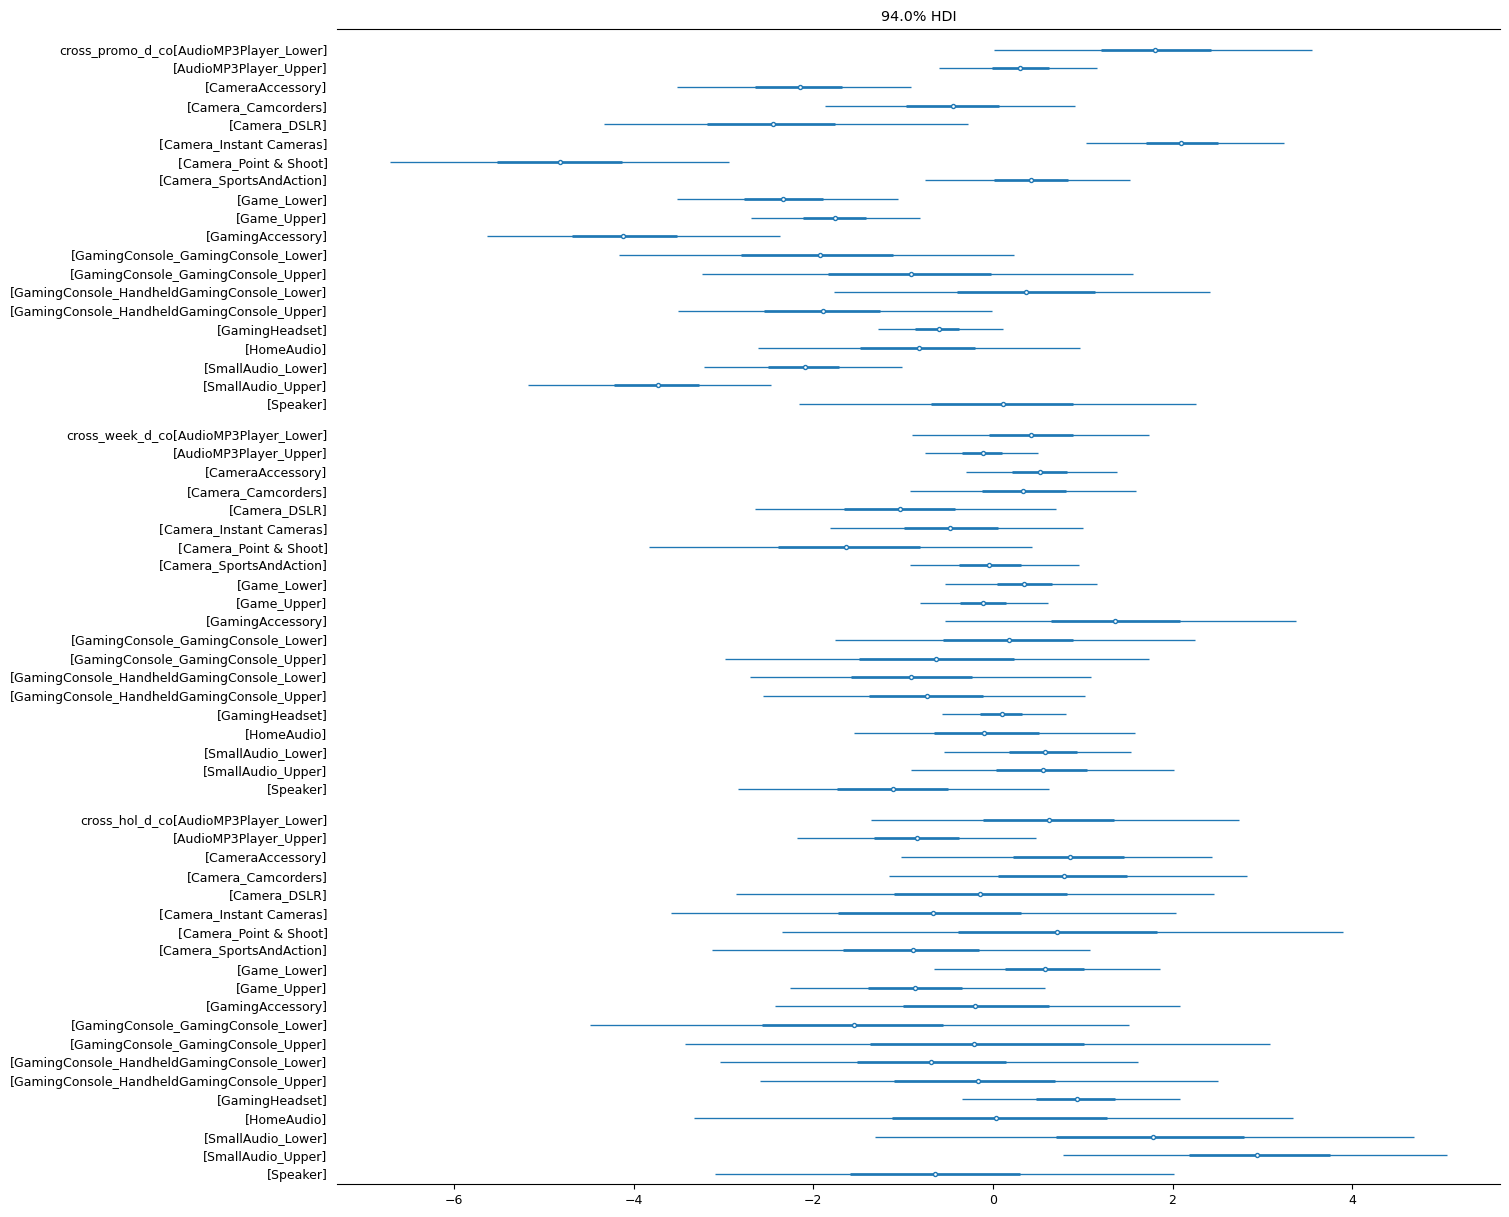

In [83]:
# Plotting all discount cross effects. Promos have the stronger effects.

ax = az.plot_forest(
    hierarchical_on_granular_trace,
    var_names=["cross_promo_d_co","cross_week_d_co","cross_hol_d_co"],
    combined=True,
    figsize=(15, 15),
    textsize=9,
)

## Takeaways

1. As expected, the strongest effect that we observe is via discounts.
2. There may be some interaction effects between the unit MRP and discounts depending on product (e.g DSLR + Speaker market). Worth investigating in the future when there is more information here to confirm our suspicion that there are no other causes to this.
3. Promos have the strongest cross interaction with discounts, in the sense that, it has more effect compared to other cross terms (e.g weekend/holiday). From a business standpoint, when the promos are more visible, user may be more likely to spend overall.
4. Ttl investment does seem to have some effect that we should take into account when building our model in our other notebook.

# Appendix

Below is a list of extra appendices used to generate some of the charts from the slides.

In [2]:
trace = az.from_netcdf('hmodel_trace.nc')

In [5]:
disc_sum = az.summary(trace,var_names=['g_d_co'])
disc_sum['mean'].mean()

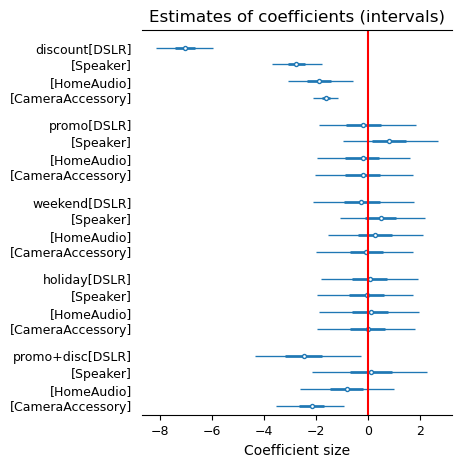

In [58]:
ax = az.plot_forest(
    trace,
    var_names=["g_d_co","promos_co","week_co","hol_co","cross_promo_d_co"],
    coords={"new_cat": ["Camera_DSLR", "Speaker","HomeAudio","CameraAccessory"]},
    combined=True,
    figsize=(4, 5),
    textsize=9,
)

ax[0].set_title('Estimates of coefficients (intervals)')
ax[0].set_xlabel('Coefficient size')

ax[0].axvline(0,c='r')
ax[0].set_yticks(ax[0].get_yticks(),['[CameraAccessory]','[HomeAudio]','[Speaker]','promo+disc[DSLR]',
                              '[CameraAccessory]','[HomeAudio]','[Speaker]','holiday[DSLR]',
                              '[CameraAccessory]','[HomeAudio]','[Speaker]','weekend[DSLR]',
                              '[CameraAccessory]','[HomeAudio]','[Speaker]','promo[DSLR]',
                               '[CameraAccessory]','[HomeAudio]','[Speaker]','discount[DSLR]',
                              ])

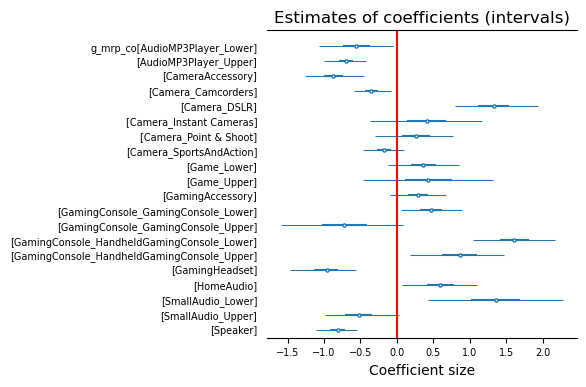

In [67]:
ax = az.plot_forest(
    trace,
    var_names=["g_mrp_co"],
    combined=True,
    figsize=(4, 4),
    textsize=7,
)
ax[0].set_title('Estimates of coefficients (intervals)')
ax[0].set_xlabel('Coefficient size')

ax[0].axvline(0,c='r')